# Transformer model for language translation

In this notebook, I am implementing from scratch the Transformer, a network architecture that was proposed in the paper "Attention Is All You Need" (Vaswani et al., Attention is all you need, Advances in neural information processing systems, 2017) and I am applying it to translate sentences from Portuguese to English. The Transformer is based solely on attention mechanisms, without any use of LSTMs or RNNs.

The dataset, the hyperparameters' values and the examples used for the evaluation were taken from https://www.tensorflow.org/tutorials/text/transformer for comparison reasons. The figures are taken from the above referenced paper.



In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import time
import numpy as np
import matplotlib.pyplot as plt

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import tensorflow_datasets as tfds
import tensorflow as tf
tf.enable_eager_execution()
tf.executing_eagerly()

print(tf.__version__)
print("Eager execution: {}".format(tf.executing_eagerly()))

config = tf.ConfigProto()
config.gpu_options.allow_growth=True

1.15.0
Eager execution: True


In [2]:
import warnings

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

Default GPU Device: /device:GPU:0


## Use of Portuguese-English translation dataset 

### The following cells which load and process the dataset were taken from https://www.tensorflow.org/tutorials/text/transformer

In [3]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True,
                               as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

In [4]:
tokenizer_en = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for pt, en in train_examples), target_vocab_size=2**13)

tokenizer_pt = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (pt.numpy() for pt, en in train_examples), target_vocab_size=2**13)

In [5]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

def encode(lang1, lang2):
  lang1 = [tokenizer_pt.vocab_size] + tokenizer_pt.encode(
      lang1.numpy()) + [tokenizer_pt.vocab_size+1]

  lang2 = [tokenizer_en.vocab_size] + tokenizer_en.encode(
      lang2.numpy()) + [tokenizer_en.vocab_size+1]
  
  return lang1, lang2

def tf_encode(pt, en):
  result_pt, result_en = tf.py_function(encode, [pt, en], [tf.int64, tf.int64])
  result_pt.set_shape([None])
  result_en.set_shape([None])

  return result_pt, result_en

MAX_LENGTH = 40

def filter_max_length(x, y, max_length=MAX_LENGTH):
    return tf.logical_and(tf.size(x) <= max_length,
                        tf.size(y) <= max_length)

In [6]:
train_preprocessed = (
    train_examples
    .map(tf_encode) 
    .filter(filter_max_length)
    # cache the dataset to memory to get a speedup while reading from it.
    .cache()
    .shuffle(BUFFER_SIZE))

val_preprocessed = (
    val_examples
    .map(tf_encode)
    .filter(filter_max_length))  

In [7]:
train_dataset = (train_preprocessed
                 .padded_batch(BATCH_SIZE, padded_shapes=([None], [None]))
                 .prefetch(tf.data.experimental.AUTOTUNE))

val_dataset = (val_preprocessed
               .padded_batch(BATCH_SIZE,  padded_shapes=([None], [None])))

In [8]:
print(tokenizer_pt.vocab_size)
print(tokenizer_en.vocab_size)

8214
8087


In [9]:
# for i in range(tokenizer_en.vocab_size):
#     print(i,tokenizer_en.decode([i]))

In [10]:
# for i in range(tokenizer_pt.vocab_size):
#     print(i,tokenizer_pt.decode([i]))

## Training dataset

In [11]:
# make the training dataset in proper format for TensorFlow 1.15
X_train = []
Y_train = []
for (batch, (inp, tar)) in enumerate(train_dataset):
    X_train.append(inp.numpy())
    Y_train.append(tar.numpy())

## Create input placeholders

In [12]:
def build_inputs():
    
    inputs_ = tf.placeholder(tf.int32,[None,None],name='inputs_')
    targets_inputs_ = tf.placeholder(tf.int32,[None,None],name='targets_inputs_')
    targets_real_ = tf.placeholder(tf.int32,[None,None],name='targets_')
    
    return inputs_, targets_inputs_, targets_real_

## Scaled dot product attention

<img src="images/scaled_dot_product_attention.png" style="width:300;height:300px;"> <br>

In [13]:
def scaled_dot_product_attention(q, k, v, mask):
 
    # matmul
    q_kTranspose = tf.matmul(q, tf.transpose(k, [0, 2, 1]))  # (batch_size, Tq, Tk)
  
    # scale 
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    logits = q_kTranspose / tf.math.sqrt(dk)

    # mask
    if mask is not None:
        logits += (mask * -1e9)  

    # softmax 
    weights = tf.nn.softmax(logits, axis=-1)  # (batch_size, Tq, Tk)

    # matmul
    output = tf.matmul(weights, v)  # (batch_size, Tq, dv)

    return output

## Multi-Head Attention

<img src="images/mha.png" style="width:300;height:300px;"> <br>

In [14]:
def multi_head_attention(v, k, q, mask, d_model, num_heads, scope):
    
    with tf.variable_scope(scope,reuse=tf.AUTO_REUSE):
    
        q = tf.contrib.layers.fully_connected(q, d_model, activation_fn = None,
                            weights_initializer = tf.keras.initializers.glorot_uniform()) 
        # (batch_size, Tq, d_model)
        k = tf.contrib.layers.fully_connected(k, d_model, activation_fn = None,
                            weights_initializer = tf.keras.initializers.glorot_uniform())
        # (batch_size, Tk, d_model)
        v = tf.contrib.layers.fully_connected(v, d_model, activation_fn = None,
                            weights_initializer = tf.keras.initializers.glorot_uniform())
        # (batch_size, Tv, d_model)
            
        q = tf.split(q, num_heads, axis=2) 
        k = tf.split(k, num_heads, axis=2) 
        v = tf.split(v, num_heads, axis=2) 
        # lists of num_heads elements with each of them having size (batch_size, T, d_model/num_heads) 
        # where T is Tq or Tk or Tv
        
        attention = []
        for head_i in range(num_heads):
            attention_i = scaled_dot_product_attention(q[head_i], k[head_i], v[head_i], mask)
            # batch_size, Tq, d_model/num_heads)
            attention.append(attention_i)
        
        concat_attention = tf.concat(attention, axis = 2) # (batch_size, Tq, d_model)
        
        output = tf.contrib.layers.fully_connected(concat_attention, d_model, activation_fn = None,
                            weights_initializer = tf.keras.initializers.glorot_uniform())
        # (batch_size, Tq, d_model)

    return output

## Position wise feed forward network

<img src="images/pwffn.png" style="width:50;height:50px;"> <br>

In [15]:
def point_wise_feed_forward_network(input_, d_model, d_ff, scope):

    with tf.variable_scope(scope,reuse=tf.AUTO_REUSE):
        x1 = tf.contrib.layers.fully_connected(input_, d_ff, activation_fn = tf.nn.relu,
                            weights_initializer = tf.keras.initializers.glorot_uniform())  
        # (batch_size, T, d_ff)
        ffn = tf.contrib.layers.fully_connected(x1, d_model, activation_fn = None,
                            weights_initializer = tf.keras.initializers.glorot_uniform()) 
        # (batch_size, T, d_model)
            
    return ffn

## Encoder layer


<img src="images/encoder_layer.png" style="width:400;height:400px;"> <br>

In [16]:
def encoder_layer(x, mask, d_model, d_ff, num_heads, rate, scope):

    with tf.variable_scope(scope,reuse=tf.AUTO_REUSE):
        attention_output = multi_head_attention(x, x, x, mask, d_model, num_heads, 'mha')
        attention_output = tf.nn.dropout(attention_output, rate = rate)
        output_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x + attention_output)
    
        ffn_output = point_wise_feed_forward_network(output_1, d_model, d_ff, 'pwffn')
        ffn_output = tf.nn.dropout(ffn_output, rate = rate)
        output_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(output_1 + ffn_output) 
    
    return output_2

## Decoder layer


<img src="images/decoder_layer.png" style="width:500;height:500px;"> <br>

In [17]:
def decoder_layer(y, encoder_output, padding_mask, future_mask, d_model, d_ff, num_heads, rate, scope):

    with tf.variable_scope(scope,reuse=tf.AUTO_REUSE):
        attention_output_1 = multi_head_attention(y, y, y, future_mask, 
                                                                    d_model, num_heads, 'mha_1')
        attention_output_1 = tf.nn.dropout(attention_output_1, rate = rate)
        output_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(y + attention_output_1)

        attention_output_2 = multi_head_attention(encoder_output, encoder_output, output_1, 
                                                                    padding_mask, d_model, num_heads, 'mha_2')
        attention_output_2 = tf.nn.dropout(attention_output_2, rate = rate)
        output_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention_output_2 + output_1) 
    
        ffn_output = point_wise_feed_forward_network(output_2, d_model, d_ff, 'pwffn')
        ffn_output = tf.nn.dropout(ffn_output, rate = rate)
        output_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(output_2 + ffn_output)
    
    return output_3

## Encoder

In [18]:
def encoder(x, mask, num_layers, d_model, num_heads, d_ff, input_vocab_size, maximum_position_encoding, rate, scope):

    with tf.variable_scope(scope,reuse=tf.AUTO_REUSE):
        
        T_x = tf.shape(x)[1]
        pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        x = tf.keras.layers.Embedding(input_vocab_size, d_model)(x) # (batch_size, T_x, d_model)
        x *= tf.math.sqrt(tf.cast(d_model, tf.float32))
        x += pos_encoding[:, :T_x, :]

        x = tf.nn.dropout(x, rate = rate)
    
        for i in range(num_layers):
            x = encoder_layer(x, mask, d_model, d_ff, num_heads, rate, 'Encoder_layer_'+str(i+1))
    
    return x  # (batch_size, T_x, d_model)

## Decoder

In [19]:
def decoder(y, encoder_output, future_mask, padding_mask, num_layers, d_model, num_heads, d_ff, 
                        target_vocab_size, maximum_position_encoding, rate, scope):

    with tf.variable_scope(scope,reuse=tf.AUTO_REUSE):   
        
        T_y = tf.shape(y)[1] 
        attention_weights = {}    
        pos_encoding = positional_encoding(maximum_position_encoding, d_model)    
    
        y = tf.keras.layers.Embedding(target_vocab_size, d_model)(y)  # (batch_size, T_y, d_model)
        y *= tf.math.sqrt(tf.cast(d_model, tf.float32))
        y += pos_encoding[:, :T_y, :]
    
        y = tf.nn.dropout(y, rate = rate)
        
        for i in range(num_layers):
            y = decoder_layer(y, encoder_output, padding_mask, future_mask, d_model, 
                                              d_ff, num_heads, rate, 'Decoder_layer_'+str(i+1))
    
    return y # (batch_size, T_y, d_model)

## Positional encoding

<img src="images/positional_encoding.png" style="width:100;height:100px;"> <br>

In [20]:
def positional_encoding(position, d_model):
        
    pos = np.arange(0,position)
    pos = pos.reshape(-1,1)
    
    div_term = 10000**(np.arange(0, d_model, 2)/d_model)
        
    pe = np.zeros((position, d_model))
    pe[:,0::2] = np.sin(pos/div_term)
    pe[:,1::2] = np.cos(pos/div_term)
        
    positional_enc = tf.convert_to_tensor(pe, dtype=tf.float32) # (position, d_model)
    positional_enc = positional_enc[np.newaxis, :,:] # (1, position, d_model)
        
    return positional_enc

## Transformer

In [21]:
def transformer(input_, target_, encoder_padding_mask, future_mask, decoder_padding_mask, num_layers, d_model, num_heads, d_ff,
                   input_vocab_size, target_vocab_size, pe_input, pe_target, rate):
    
    
    encoder_output = encoder(input_, encoder_padding_mask, num_layers, d_model, num_heads, d_ff, input_vocab_size, 
                                        pe_input, rate, 'Encoder')

    decoder_output = decoder(target_, encoder_output, future_mask, decoder_padding_mask, 
                                          num_layers, d_model, num_heads, d_ff, target_vocab_size, pe_target, rate, 'Decoder')

    final_output = tf.contrib.layers.fully_connected(decoder_output, target_vocab_size, activation_fn = None,
                            weights_initializer = tf.keras.initializers.glorot_uniform())
    
    return final_output

## Learning rate


<img src="images/lrate.png" style="width:50;height:50px;"> <br>

In [22]:
def learning_rate_function(d_model, step_num):
    
    warmup_steps = 4000

    step_num = tf.cast(step_num + 1,tf.float32)
    d_model = tf.cast(d_model, tf.float32)
    
    part1 = tf.math.rsqrt(step_num)
    part2 = step_num * (warmup_steps ** (-1.5))
    
    learning_rate = tf.math.rsqrt(d_model) * tf.math.minimum(part1, part2)
    
    return learning_rate

## Loss

In [23]:
def loss_function(target_, prediction_):
  
    mask = tf.math.logical_not(tf.math.equal(target_, 0))
    
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')(target_, prediction_)

    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
  
    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
    
    return loss

## Accuracy

In [24]:
def accuracy_function(target_, prediction_):
    
    accuracy = tf.reduce_mean(tf.cast(tf.equal(target_,tf.cast(tf.argmax(prediction_, axis=-1),dtype=tf.int32)),dtype=tf.float32))
    
    return accuracy

## Optimizer

In [25]:
def optimizer_function(loss, d_model):
    
    global_step = tf.Variable(0, trainable=False) 
    learning_rate = learning_rate_function(d_model, global_step)
    optimizer = tf.train.AdamOptimizer(learning_rate, beta1=0.9, beta2=0.98, epsilon=1e-09).minimize(loss, global_step)
     
    return optimizer

## Masks

In [26]:
def padding_mask_function(input_):
    
    input_ = tf.cast(tf.math.equal(input_, 0), tf.float32) # (batch_size, T)
  
    # add extra dimension to add the padding to the attention logits
    return input_[:, tf.newaxis, :]  # (batch_size, 1, T)

In [27]:
def future_mask_function(batch_size_, size):
    
    diag_vals = tf.ones((size, size))  # (T, T)
    tril = 1 - tf.linalg.LinearOperatorLowerTriangular(diag_vals).to_dense() # (T, T)
    mask = tf.tile(tril[tf.newaxis, :, :], [batch_size_, 1, 1]) # (batch_size_, T, T)

    return mask  

In [28]:
def create_masks(input_, target_):
    
    # used in the input of the encoder to mask the padding tokens
    encoder_padding_mask = padding_mask_function(input_)
    
    # Used in the 1st attention block of the decoder to mask the padding tokens of the decoder input 
    # and prevent positions from attending to subsequent positions of the decoder input 
    future_mask = future_mask_function(tf.shape(target_)[0], tf.shape(target_)[1])
    decoder_target_padding_mask = padding_mask_function(target_)
    future_pad_mask = tf.maximum(decoder_target_padding_mask, future_mask)
  
    # used in the 2nd attention block of the decoder to mask the padding tokens of the encoder outputs
    decoder_padding_mask = padding_mask_function(input_)
  
    return encoder_padding_mask, future_pad_mask, decoder_padding_mask

## Transformer

In [29]:
class transformer_model:
    
    def __init__(self, num_layers, d_model, num_heads, d_ff, input_vocab_size, target_vocab_size, pe_input, 
                       pe_target, rate):
        
        tf.reset_default_graph()
        
        # Build the input placeholder tensors
        self.inputs_, self.targets_inputs_, self.targets_real_ = build_inputs()
        
        encoder_padding_mask, future_pad_mask, decoder_padding_mask = create_masks(self.inputs_, self.targets_inputs_)
        
        self.predictions = transformer(self.inputs_, self.targets_inputs_, encoder_padding_mask, future_pad_mask, 
                                     decoder_padding_mask,  num_layers, d_model, num_heads, d_ff, input_vocab_size, 
                                     target_vocab_size, pe_input, pe_target, rate)
        
        # Loss
        self.loss = loss_function(self.targets_real_, self.predictions)
        
        # Accuracy
        self.accuracy = accuracy_function(self.targets_real_, self.predictions)
        
        # Optimizer
        self.optimizer = optimizer_function(self.loss, d_model)

## Hyperparameters

In [30]:
num_layers = 4
d_model = 128
d_ff = 512
num_heads = 8

input_vocab_size = tokenizer_pt.vocab_size + 2
target_vocab_size = tokenizer_en.vocab_size + 2
dropout_rate = 0.1

num_epochs = 20

## Training

In [32]:
tf.disable_eager_execution()
tf.reset_default_graph()

model = transformer_model(num_layers = num_layers, d_model = d_model, num_heads = num_heads, d_ff = d_ff, 
                          input_vocab_size = input_vocab_size, target_vocab_size = target_vocab_size, 
                          pe_input = input_vocab_size, pe_target = target_vocab_size, rate = dropout_rate)

saver = tf.train.Saver(max_to_keep=num_epochs) 
checkpoint_folder = 'checkpoints_transformer'

start_total = time.time()

with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    
    train_loss_per_step = []
    train_loss_per_epoch = []
    train_accuracy_per_epoch = []
    
    for epoch in range(num_epochs):
        start = time.time()
        
        train_loss_per_batch = []
        train_accuracy_per_batch = []
        
        for batch in range(len(X_train)):
            
            inputs_ = X_train[batch]
            targets_inputs_ = Y_train[batch][:, :-1]
            targets_real_ = Y_train[batch][:, 1:]

            feed = {model.inputs_: inputs_,
                   model.targets_inputs_: targets_inputs_,
                   model.targets_real_: targets_real_}

    
            batch_predictions, batch_loss, batch_accuracy, _ = sess.run([model.predictions,
                                                 model.loss,
                                                 model.accuracy,
                                                 model.optimizer],
                                                 feed_dict=feed)
        
            
            train_loss_per_batch.append(batch_loss)
            train_loss_per_step.append(batch_loss)
            train_accuracy_per_batch.append(batch_accuracy)
            
        train_loss_per_epoch.append(np.mean(train_loss_per_batch))
        train_accuracy_per_epoch.append(np.mean(train_accuracy_per_batch))
        
        print("Epoch: {}/{}".format(epoch+1, num_epochs),
              "Mean loss  : {:.4f}".format(np.mean(train_loss_per_batch)),
              "Mean accuracy  : {:.4f}".format(np.mean(train_accuracy_per_batch)))
        
    saver.save(sess, checkpoint_folder+'/transformer.ckpt')
    print ('Time taken for ALL epochs: {} secs\n'.format(time.time() - start_total))

Epoch: 1/20 Mean loss  : 7.1167 Mean accuracy  : 0.0508
Epoch: 2/20 Mean loss  : 5.0024 Mean accuracy  : 0.1258
Epoch: 3/20 Mean loss  : 4.4511 Mean accuracy  : 0.1512
Epoch: 4/20 Mean loss  : 4.0000 Mean accuracy  : 0.1752
Epoch: 5/20 Mean loss  : 3.5342 Mean accuracy  : 0.2021
Epoch: 6/20 Mean loss  : 3.1338 Mean accuracy  : 0.2232
Epoch: 7/20 Mean loss  : 2.7316 Mean accuracy  : 0.2454
Epoch: 8/20 Mean loss  : 2.4082 Mean accuracy  : 0.2640
Epoch: 9/20 Mean loss  : 2.1739 Mean accuracy  : 0.2779
Epoch: 10/20 Mean loss  : 1.9993 Mean accuracy  : 0.2883
Epoch: 11/20 Mean loss  : 1.8562 Mean accuracy  : 0.2975
Epoch: 12/20 Mean loss  : 1.7389 Mean accuracy  : 0.3052
Epoch: 13/20 Mean loss  : 1.6423 Mean accuracy  : 0.3111
Epoch: 14/20 Mean loss  : 1.5561 Mean accuracy  : 0.3170
Epoch: 15/20 Mean loss  : 1.4852 Mean accuracy  : 0.3218
Epoch: 16/20 Mean loss  : 1.4178 Mean accuracy  : 0.3263
Epoch: 17/20 Mean loss  : 1.3592 Mean accuracy  : 0.3307
Epoch: 18/20 Mean loss  : 1.3034 Mean ac

## Figures of loss and accuracy

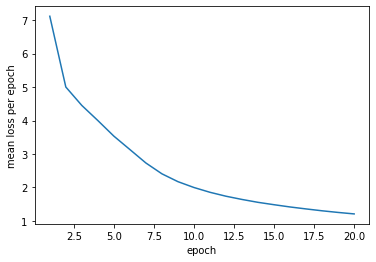

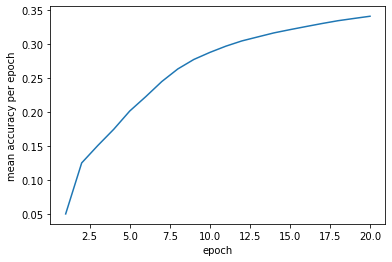

In [33]:
fig = plt.figure()
plt.plot(np.arange(1,num_epochs+1), train_loss_per_epoch)
plt.ylabel('mean loss per epoch')
plt.xlabel('epoch')
fig.savefig('./'+ checkpoint_folder +'/mean loss per epoch.png')

fig = plt.figure()
plt.plot(np.arange(1,num_epochs+1), train_accuracy_per_epoch)
plt.ylabel('mean accuracy per epoch')
plt.xlabel('epoch')
fig.savefig('./'+ checkpoint_folder +'/mean accuracy per epoch.png')

## Evaluate 

### The funtions 'evaluate' and 'translate' and the testing examples were taken from https://www.tensorflow.org/tutorials/text/transformer which uses TensorFlow 2.0 and were modified accordingly for TensorFlow 1.15

In [34]:
def evaluate(inp_sentence):

    dropout_rate = 0
    start_token = [tokenizer_pt.vocab_size]
    end_token = [tokenizer_pt.vocab_size + 1]
    
    inp_sentence = start_token + tokenizer_pt.encode(inp_sentence) + end_token
    encoder_input = np.expand_dims(inp_sentence, 0)
    
    decoder_input = [tokenizer_en.vocab_size]
    output = np.expand_dims(decoder_input, 0)

    model = transformer_model(num_layers = num_layers, d_model = d_model, num_heads = num_heads, d_ff = d_ff, 
                          input_vocab_size = input_vocab_size, target_vocab_size = target_vocab_size, 
                          pe_input = input_vocab_size, pe_target = target_vocab_size, rate = dropout_rate)

    with tf.Session() as sess:
        
        saver = tf.train.Saver()
        saver.restore(sess, tf.train.latest_checkpoint(checkpoint_folder))

        for i in range(MAX_LENGTH):
            
            feed = {model.inputs_: encoder_input,
                   model.targets_inputs_: output,
                   model.targets_real_: output}
            
            batch_predictions = sess.run(model.predictions, feed_dict=feed)
                    
            # select the last word from the Ty dimension
            predictions = batch_predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)
            
            predicted_id = np.argmax(predictions, axis=-1)
            predicted_id = predicted_id.astype(int)
            
            # return the result if the predicted_id is equal to the end token
            if predicted_id == tokenizer_en.vocab_size+1:
                return np.squeeze(output, axis=0)
        
            # concatentate the predicted_id to the output which is given to the decoder # as its input.
            output = np.concatenate((output, predicted_id), axis=-1)
    
        return np.squeeze(output, axis=0)

In [35]:
def translate(sentence):
    
    result = evaluate(sentence)
  
    predicted_sentence = tokenizer_en.decode([i for i in result 
                                            if i < tokenizer_en.vocab_size])  

    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(predicted_sentence))

### Example 1

In [36]:
translate("este é um problema que temos que resolver.")
print ("Real translation: this is a problem we have to solve .")

INFO:tensorflow:Restoring parameters from checkpoints_transformer/transformer.ckpt


INFO:tensorflow:Restoring parameters from checkpoints_transformer/transformer.ckpt


Input: este é um problema que temos que resolver.
Predicted translation: this is a problem that we have to solve .
Real translation: this is a problem we have to solve .


### Example 2

In [37]:
translate("os meus vizinhos ouviram sobre esta ideia.")
print ("Real translation: and my neighboring homes heard about this idea .")

INFO:tensorflow:Restoring parameters from checkpoints_transformer/transformer.ckpt


INFO:tensorflow:Restoring parameters from checkpoints_transformer/transformer.ckpt


Input: os meus vizinhos ouviram sobre esta ideia.
Predicted translation: my neighbors heard about this idea .
Real translation: and my neighboring homes heard about this idea .


### Example 3

In [38]:
translate("vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.")
print ("Real translation: so i 'll just share with you some stories very quickly of some magical things that have happened .")

INFO:tensorflow:Restoring parameters from checkpoints_transformer/transformer.ckpt


INFO:tensorflow:Restoring parameters from checkpoints_transformer/transformer.ckpt


Input: vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Predicted translation: so i 'm going to share very quickly share with you some magic stories that happened there .
Real translation: so i 'll just share with you some stories very quickly of some magical things that have happened .


## Number of trainable parameters

In [39]:
model = transformer_model(num_layers = num_layers, d_model = d_model, num_heads = num_heads, d_ff = d_ff, 
                          input_vocab_size = input_vocab_size, target_vocab_size = target_vocab_size, 
                          pe_input = input_vocab_size, pe_target = target_vocab_size, rate = dropout_rate)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    total_parameters = 0
    for variable in tf.trainable_variables():
        print(variable)
        # shape is an array of tf.Dimension
        shape = variable.get_shape()
        variable_parameters = 1
        for dim in shape:
            variable_parameters *= dim.value

        total_parameters += variable_parameters
    print('total number of trainable parameters: ',total_parameters)

<tf.Variable 'Encoder/embedding/embeddings:0' shape=(8216, 128) dtype=float32>
<tf.Variable 'Encoder/Encoder_layer_1/mha/fully_connected/weights:0' shape=(128, 128) dtype=float32_ref>
<tf.Variable 'Encoder/Encoder_layer_1/mha/fully_connected/biases:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'Encoder/Encoder_layer_1/mha/fully_connected_1/weights:0' shape=(128, 128) dtype=float32_ref>
<tf.Variable 'Encoder/Encoder_layer_1/mha/fully_connected_1/biases:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'Encoder/Encoder_layer_1/mha/fully_connected_2/weights:0' shape=(128, 128) dtype=float32_ref>
<tf.Variable 'Encoder/Encoder_layer_1/mha/fully_connected_2/biases:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'Encoder/Encoder_layer_1/mha/fully_connected_3/weights:0' shape=(128, 128) dtype=float32_ref>
<tf.Variable 'Encoder/Encoder_layer_1/mha/fully_connected_3/biases:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'Encoder/Encoder_layer_1/layer_normalization/gamma:0' shape=(128,) dtype=flo